<a href="https://colab.research.google.com/github/KARTH33K/Deep-Learning/blob/main/American_Airlines_Twitter_Sentiment_Nov_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter sentiment analysis using NLTK Sentiment Intensity Analyzer

I am interested in the twitter comments about the American Airlines services and flights. I will scrape `10000` tweets from the American Airlines in `Nov 2022` to perform the investigation.

Inspection gives a detailed look at the overall sentiment of the airline in the cusomters.

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# for sentiment analysis

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Scraping Tweets

In [ ]:
!pip install snscrape
import snscrape.modules.twitter as sntwitter
import csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 2.2 MB/s 


In [ ]:
maxTweets = 9999
attributes_container = [] #initialize empty list, append with tweets later

# Scappring user tweets on American Airlines
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('@AmericanAir + since:2022-11-15 until:2022-12-02').get_items()): 

  if i > maxTweets :
    break
  attributes_container.append([tweet.id, tweet.date, tweet.content]) # also append the tweets to a list, so that, we can save to a dataframe at the end.

tweets_df = pd.DataFrame(attributes_container, columns=["id", "Date Created", "Tweet"]) #save to the dataframe, so that, we can easliy save to CSV later

print('No of tweets in the dataset: ',len(tweets_df.index))

No of tweets in the dataset:  10000


### View the first and last 5 tweets

In [ ]:
tweets_df.head() # first tweets refer to united airlines

,id,Date Created,Tweet
0,1598466900106907650,2022-12-01 23:59:41+00:00,@cpwrpas Thanks for bringing this to our atten...
1,1598466490621399040,2022-12-01 23:58:04+00:00,What's being done to respond to complaints of ...
2,1598466434732298240,2022-12-01 23:57:50+00:00,@AmericanAir how do you not know before now th...
3,1598466250094833664,2022-12-01 23:57:06+00:00,"@AmericanAir Just got another non response, re..."
4,1598466097514151943,2022-12-01 23:56:30+00:00,@AmericanAir checking in with service dog. Th...


### Save to CSV

In [ ]:
tweets_df.to_csv('/content/airlines_tweets.csv', index=False) # save dataframe with tweets to a csv 

## Copy Twitter_df to df for data prep and modelling consistency

In [ ]:
#df = pd.read_csv('/content/airlines_tweets.csv')
df = tweets_df.copy()
df.head()

,id,Date Created,Tweet
0,1598466900106907650,2022-12-01 23:59:41+00:00,@cpwrpas Thanks for bringing this to our atten...
1,1598466490621399040,2022-12-01 23:58:04+00:00,What's being done to respond to complaints of ...
2,1598466434732298240,2022-12-01 23:57:50+00:00,@AmericanAir how do you not know before now th...
3,1598466250094833664,2022-12-01 23:57:06+00:00,"@AmericanAir Just got another non response, re..."
4,1598466097514151943,2022-12-01 23:56:30+00:00,@AmericanAir checking in with service dog. Th...


## Word cloud

### Lowercase conversion

In [ ]:
df['Tweet'] = df['Tweet'].str.lower()
df.head()

,id,Date Created,Tweet
0,1598466900106907650,2022-12-01 23:59:41+00:00,@cpwrpas thanks for bringing this to our atten...
1,1598466490621399040,2022-12-01 23:58:04+00:00,what's being done to respond to complaints of ...
2,1598466434732298240,2022-12-01 23:57:50+00:00,@americanair how do you not know before now th...
3,1598466250094833664,2022-12-01 23:57:06+00:00,"@americanair just got another non response, re..."
4,1598466097514151943,2022-12-01 23:56:30+00:00,@americanair checking in with service dog. th...


### Strip funky characters

In [ ]:
df['Tweet'] = df['Tweet'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
df.head()

<ipython-input-11-c2e11f0f492a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Tweet'] = df['Tweet'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()


,id,Date Created,Tweet
0,1598466900106907650,2022-12-01 23:59:41+00:00,cpwrpas thanks for bringing this to our attent...
1,1598466490621399040,2022-12-01 23:58:04+00:00,whats being done to respond to complaints of d...
2,1598466434732298240,2022-12-01 23:57:50+00:00,americanair how do you not know before now tha...
3,1598466250094833664,2022-12-01 23:57:06+00:00,americanair just got another non response resp...
4,1598466097514151943,2022-12-01 23:56:30+00:00,americanair checking in with service dog thank...


### Stop words

In [ ]:
# Remove some of the common stop words
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords') # this makes sure these are downloaded if you haven't already
print(stopwords.words('english'))

stop = stopwords.words('english')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# remove the stop words
df.head() 
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # apply the transformation to the tweet column
df.head()

,id,Date Created,Tweet
0,1598466900106907650,2022-12-01 23:59:41+00:00,cpwrpas thanks bringing attention tsa screens ...
1,1598466490621399040,2022-12-01 23:58:04+00:00,whats done respond complaints discrimination r...
2,1598466434732298240,2022-12-01 23:57:50+00:00,americanair know pilot flown many hours fly ho...
3,1598466250094833664,2022-12-01 23:57:06+00:00,americanair got another non response response ...
4,1598466097514151943,2022-12-01 23:56:30+00:00,americanair checking service dog thank plenty ...


### Frequent words

In [ ]:
# identiy the top frequrntly occuring words in the dataset
myTable = df['Tweet'].str.split(expand=True).stack().value_counts()
myTable[0:20] # top 20 frequent words 

americanair      7510
flight           1880
us               1303
get               778
dm                740
well              675
please            673
time              559
like              544
would             543
dms               491
help              490
see               487
service           481
im                460
marcuslemonis     460
team              452
one               424
sorry             420
dont              417
dtype: int64

In [ ]:
print('Total number of unique words in dataset:', str(len(myTable)))

Total number of unique words in dataset: 17047


In [ ]:
# Make a frequency plot 
# group, then convert to pandas DataFrame for easy plotting
x = df['Tweet'].str.split(expand=True).stack().value_counts()
x = pd.DataFrame(x)
# reset the index
x.reset_index(inplace=True)
# rename the columns
x.rename(columns={x.columns[0]:'word', x.columns[1]:'frequency'}, inplace=True)
x.head()

,word,frequency
0,americanair,7510
1,flight,1880
2,us,1303
3,get,778
4,dm,740


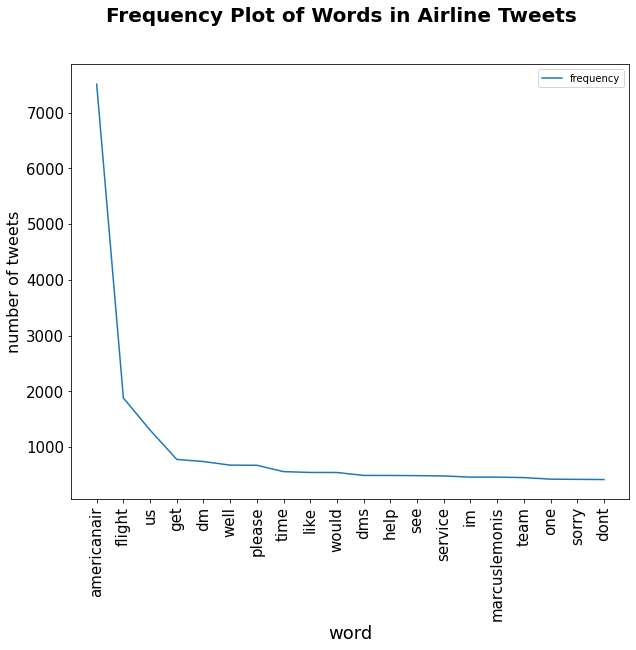

In [ ]:
# Frequency Distribution Plot
x = x[0:20] # plotting frequency curve for top 20 frequently occuring words 

x.plot(x='word', y='frequency',figsize=(10, 8), fontsize=15)
plt.xticks(np.arange(len(x)), x['word'], rotation=90)
plt.suptitle('Frequency Plot of Words in Airline Tweets', fontweight='bold', fontsize=20)
plt.xlabel('word', fontsize=18)
plt.ylabel('number of tweets', fontsize=16)
plt.show()

In [ ]:
df

,id,Date Created,Tweet
0,1598466900106907650,2022-12-01 23:59:41+00:00,cpwrpas thanks bringing attention tsa screens ...
1,1598466490621399040,2022-12-01 23:58:04+00:00,whats done respond complaints discrimination r...
2,1598466434732298240,2022-12-01 23:57:50+00:00,americanair know pilot flown many hours fly ho...
3,1598466250094833664,2022-12-01 23:57:06+00:00,americanair got another non response response ...
4,1598466097514151943,2022-12-01 23:56:30+00:00,americanair checking service dog thank plenty ...
...,...,...,...
9995,1594369403600228352,2022-11-20 16:37:42+00:00,iflymia americanair southwestair spiritairline...
9996,1594368618128674819,2022-11-20 16:34:35+00:00,myepezt team always assisting best way possibl...
9997,1594368457629642752,2022-11-20 16:33:56+00:00,americanair httpstcovzgfzrbrt
9998,1594368114413932544,2022-11-20 16:32:35+00:00,elisokol food sale offered select flights depe...


### Remove Too frequent word - 'americanair'

In [ ]:
# import
nltk.download('punkt')
from nltk.tokenize import word_tokenize

sw_list = ['americanair','flight','us']
stop.extend(sw_list) # update the stop word list

text_tokens = word_tokenize(str(df["Tweet"]))
tokens_without_sw = [word for word in text_tokens if not word in stop]

print(tokens_without_sw) # now 'united' and 'americanair' are gone

['0', 'cpwrpas', 'thanks', 'bringing', 'attention', 'tsa', 'screens', '...', '1', 'whats', 'done', 'respond', 'complaints', 'discrimination', 'r', '...', '2', 'know', 'pilot', 'flown', 'many', 'hours', 'fly', 'ho', '...', '3', 'got', 'another', 'non', 'response', 'response', '...', '4', 'checking', 'service', 'dog', 'thank', 'plenty', '...', '...', '9995', 'iflymia', 'southwestair', 'spiritairline', '...', '9996', 'myepezt', 'team', 'always', 'assisting', 'best', 'way', 'possibl', '...', '9997', 'httpstcovzgfzrbrt', '9998', 'elisokol', 'food', 'sale', 'offered', 'select', 'flights', 'depe', '...', '9999', 'lucreziab', 'lets', 'take', 'closer', 'look', 'pop', 'dms', 'record', '...', 'Name', ':', 'Tweet', ',', 'Length', ':', '10000', ',', 'dtype', ':', 'object']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 
df.head() # to check 'united' gone

,id,Date Created,Tweet
0,1598466900106907650,2022-12-01 23:59:41+00:00,cpwrpas thanks bringing attention tsa screens ...
1,1598466490621399040,2022-12-01 23:58:04+00:00,whats done respond complaints discrimination r...
2,1598466434732298240,2022-12-01 23:57:50+00:00,know pilot flown many hours fly hour delayed r...
3,1598466250094833664,2022-12-01 23:57:06+00:00,got another non response response say american...
4,1598466097514151943,2022-12-01 23:56:30+00:00,checking service dog thank plenty time thank a...


In [ ]:
df.tail() # to check 'americanair' gone

,id,Date Created,Tweet
9995,1594369403600228352,2022-11-20 16:37:42+00:00,iflymia southwestair spiritairlines united can...
9996,1594368618128674819,2022-11-20 16:34:35+00:00,myepezt team always assisting best way possibl...
9997,1594368457629642752,2022-11-20 16:33:56+00:00,httpstcovzgfzrbrt
9998,1594368114413932544,2022-11-20 16:32:35+00:00,elisokol food sale offered select flights depe...
9999,1594368102996840461,2022-11-20 16:32:32+00:00,lucreziab lets take closer look pop dms record...


Again plotting the frequency table after stripping the too frequenct words

In [ ]:
myTable = df['Tweet'].str.split(expand=True).stack().value_counts()
myTable[0:20] # top 20 frequently occuring words

get              778
dm               740
well             675
please           673
time             559
like             544
would            543
dms              491
help             490
see              487
service          481
im               460
marcuslemonis    460
team             452
one              424
sorry            420
dont             417
take             413
aa               410
thanks           408
dtype: int64

In [ ]:
print('Total number of unique words in dataset:', str(len(myTable)))

Total number of unique words in dataset: 17044


In [ ]:
# Make a frequency plot 
# group, then convert to pandas DataFrame for easy plotting
x = df['Tweet'].str.split(expand=True).stack().value_counts()
x = pd.DataFrame(x)
# reset the index
x.reset_index(inplace=True)
# rename the columns
x.rename(columns={x.columns[0]:'word', x.columns[1]:'frequency'}, inplace=True)
x.head()

,word,frequency
0,get,778
1,dm,740
2,well,675
3,please,673
4,time,559


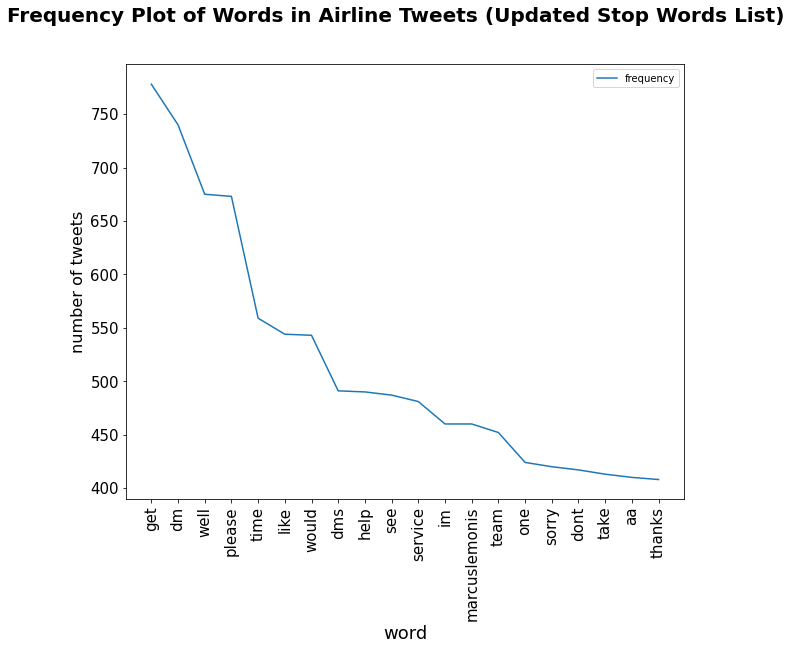

In [ ]:
# Frequency Distribution Plot
x = x[0:20] # plotting frequency curve for top 20 frequently occuring words 

x.plot(x='word', y='frequency',figsize=(10, 8), fontsize=15)
plt.xticks(np.arange(len(x)), x['word'], rotation=90)
plt.suptitle('Frequency Plot of Words in Airline Tweets (Updated Stop Words List)', fontweight='bold', fontsize=20)
plt.xlabel('word', fontsize=18)
plt.ylabel('number of tweets', fontsize=16)
plt.show()

## Word cloud

In [ ]:
from wordcloud import WordCloud

from PIL import *
from PIL import Image

import urllib.request
import cv2 as cv
import cv2
from google.colab.patches import cv2_imshow
from skimage import io 

In [ ]:
url = 'https://www.edigitalagency.com.au/wp-content/uploads/Twitter-logo-png-1.png'
#url_response = urllib.request.urlopen(url)
myImg = io.imread(url)
cv.imwrite('Twitter_logo.png', cv.cvtColor(myImg,cv.COLOR_BGR2GRAY)) # save as grayscale; less space; faster execution

True

In [ ]:
mask_twitter = np.array(Image.open('/content/Twitter_logo.png')) # creating word cloud inside twitter logo
print(mask_twitter)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# chaning background colors to white for creating a proper mask from png
def transform_zeros(val):
    if val == 0: 
       return 255
    else:
       return val

maskable_image = np.ndarray((mask_twitter.shape[0],mask_twitter.shape[1]), np.int32)
for i in range(len(mask_twitter)):
    maskable_image[i] = list(map(transform_zeros, mask_twitter[i]))

print(maskable_image)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [ ]:
 mask_twitter = maskable_image

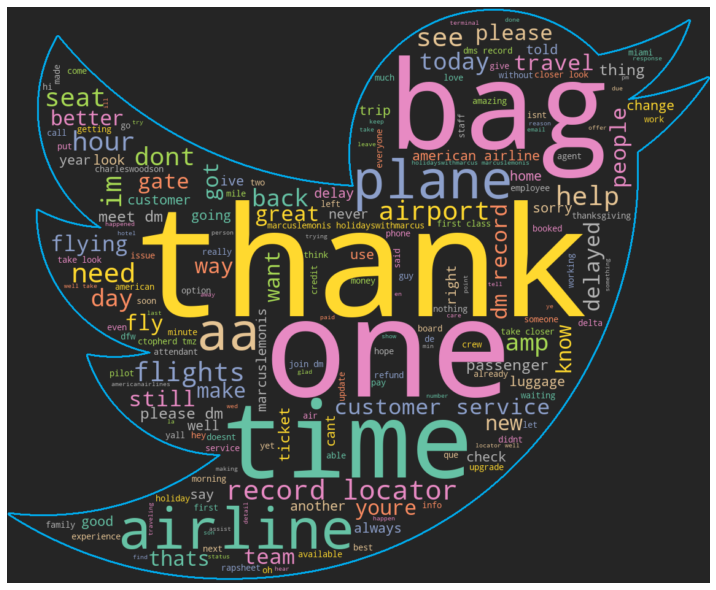

In [ ]:
wordcloud = WordCloud(mask = mask_twitter, background_color="#252525", colormap="Set2", contour_color='#00acee', contour_width=1.5).generate(' '.join(df['Tweet']))

plt.figure(figsize=(12,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Tokenizer

In [ ]:
# tokenizer
df['Tweet_featured'] = df.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)
df.head()

,id,Date Created,Tweet,Tweet_featured
0,1598466900106907650,2022-12-01 23:59:41+00:00,cpwrpas thanks bringing attention tsa screens ...,"[cpwrpas, thanks, bringing, attention, tsa, sc..."
1,1598466490621399040,2022-12-01 23:58:04+00:00,whats done respond complaints discrimination r...,"[whats, done, respond, complaints, discriminat..."
2,1598466434732298240,2022-12-01 23:57:50+00:00,know pilot flown many hours fly hour delayed r...,"[know, pilot, flown, many, hours, fly, hour, d..."
3,1598466250094833664,2022-12-01 23:57:06+00:00,got another non response response say american...,"[got, another, non, response, response, say, a..."
4,1598466097514151943,2022-12-01 23:56:30+00:00,checking service dog thank plenty time thank a...,"[checking, service, dog, thank, plenty, time, ..."


## Lexicon stemming

In [ ]:
# cuts down on dimensionality 

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# function used
ps = PorterStemmer()

filtered_sent = df['Tweet_featured'][2]

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

# example observation
print("Filtered Sentence:",filtered_sent) 
print("Stemmed Sentence:",stemmed_words)

Filtered Sentence: ['know', 'pilot', 'flown', 'many', 'hours', 'fly', 'hour', 'delayed', 'rdu', 'lhr', 'isnt', 'something', 'could', 'known', 'hours', 'ago', 'got', 'another', 'pilot', 'amaze', 'ineptitude']
Stemmed Sentence: ['know', 'pilot', 'flown', 'mani', 'hour', 'fli', 'hour', 'delay', 'rdu', 'lhr', 'isnt', 'someth', 'could', 'known', 'hour', 'ago', 'got', 'anoth', 'pilot', 'amaz', 'ineptitud']


In [ ]:
# Making a new column with just the stemmed words
df['Tweet_stemmed'] = df['Tweet_featured'].apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.

In [ ]:
# Duplicate the column for future use.
df['Tweet_Steemmed_2'] = df['Tweet_featured'].apply(lambda x: [ps.stem(y) for y in x]) 

In [ ]:
# check the work!
# example observations

# United Airlines tweets
print(df['Tweet_featured'][450]) 
print(df['Tweet_stemmed'][450]) 

# American airlines tweets
print(df['Tweet_featured'][1296])
print(df['Tweet_stemmed'][1296]) 

['excited', 'arrive', 'time', 'nhtoymc', 'ncss', 'session', 'looking', 'like', 'ill', 'miss', 'stuck', 'gate', 'min', 'still', 'havent', 'deplaned', 'fomo', 'httpstcogzmyfdwim']
['excit', 'arriv', 'time', 'nhtoymc', 'ncss', 'session', 'look', 'like', 'ill', 'miss', 'stuck', 'gate', 'min', 'still', 'havent', 'deplan', 'fomo', 'httpstcogzmyfdwim']
['irinilyg', 'take', 'closer', 'look', 'please', 'provide', 'record', 'locator', 'details', 'via', 'dm']
['irinilyg', 'take', 'closer', 'look', 'pleas', 'provid', 'record', 'locat', 'detail', 'via', 'dm']


In [ ]:
# check the updated dataframe
df.head()

## Sentiment Score Calculation

### Conversion "Tweet_Stemmed' to list

In [ ]:
type(df.Tweet_stemmed)

In [ ]:
# Extracting all tweets to a dataframe, and converting to a list later
sentences = df['Tweet_stemmed']

In [ ]:
sentences

0       [cpwrpa, thank, bring, attent, tsa, screen, ba...
1       [what, done, respond, complaint, discrimin, re...
2       [know, pilot, flown, mani, hour, fli, hour, de...
3       [got, anoth, non, respons, respons, say, ameri...
4       [check, servic, dog, thank, plenti, time, than...
                              ...                        
9995    [iflymia, southwestair, spiritairlin, unit, ca...
9996    [myepezt, team, alway, assist, best, way, poss...
9997                                  [httpstcovzgfzrbrt]
9998    [elisokol, food, sale, offer, select, flight, ...
9999    [lucreziab, let, take, closer, look, pop, dm, ...
Name: Tweet_stemmed, Length: 10000, dtype: object

In [ ]:
# join the words in sentences
i = 0
while i < len(sentences):
  sentences[i] = ' '.join(sentences[i])
  i += 1

sentences

<ipython-input-41-2753b658bd0f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentences[i] = ' '.join(sentences[i])


0       cpwrpa thank bring attent tsa screen baggag lo...
1       what done respond complaint discrimin refer mi...
2       know pilot flown mani hour fli hour delay rdu ...
3       got anoth non respons respons say americanairl...
4       check servic dog thank plenti time thank aa ti...
                              ...                        
9995    iflymia southwestair spiritairlin unit cant ga...
9996    myepezt team alway assist best way possibl ple...
9997                                    httpstcovzgfzrbrt
9998    elisokol food sale offer select flight depend ...
9999    lucreziab let take closer look pop dm record w...
Name: Tweet_stemmed, Length: 10000, dtype: object

In [ ]:
type(sentences) # Need to be a list

pandas.core.series.Series

In [ ]:
# Series are to be converted to list for SentimentIntensityAnalyzer() method
sentences_encode = sentences.tolist()

In [ ]:
sentences_encode # view the list

['cpwrpa thank bring attent tsa screen baggag load board safeti custom crew',
 'what done respond complaint discrimin refer minor j n word okayamericanair adl httpstcojwmkqwewo',
 'know pilot flown mani hour fli hour delay rdu lhr isnt someth could known hour ago got anoth pilot amaz ineptitud',
 'got anoth non respons respons say americanairlinessuck absolut resolut specif concern address im sure disconnect promis compens receiv',
 'check servic dog thank plenti time thank aa ticket counter worker educ job check servic dog took hour get properli check due paperwork complic httpstcoswwlxyu',
 'shout american airlin terribl experi jet blue hate pet aa complet opposit couldnt nicer check thank great travel experi',
 'clemstweet red eye den tb frontier right attend start accept tip neveragain',
 'brittcollen your welcom alway need',
 'cpinav could agre worst',
 'thank im desk',
 'brittcollen wed happi help rebook need dm record locat',
 'jtgenter know',
 'say guy speedi twitter haha wish 

### Import SentimentIntensityAnalyzer

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Initialize empty columns: 'Compounds', 'pos', 'neu', 'neg'

In [ ]:
# Initialize 4 empty columns to store the sentiment values into them
df['compounds'] = ''
df['neg'] = ''
df['pos'] = ''
df['neu'] = ''

### Compute & update DF with the values of 'Compounds', 'pos', 'neu', 'neg'

In [ ]:
i = 0
for sentence in sentences_encode:
  sid = SentimentIntensityAnalyzer()
  print(sentence)
  ss = sid.polarity_scores(sentence)
  
  for k in sorted(ss):
    print('{0}: {1}, '.format(k, ss[k]), end='')
    df['compounds'][i] = ss['compound'] # store the value of compound key into corresponding column
    df['neg'][i] = ss['neg'] # store the value of neg key into corresponding column
    df['pos'][i] = ss['pos'] # store the value of pos key into corresponding column
    df['neu'][i] = ss['neu'] # store the value of neu key into corresponding column

  i += 1
  print()

<ipython-input-48-003ddfef0b39>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compounds'][i] = ss['compound'] # store the value of compound key into corresponding column
<ipython-input-48-003ddfef0b39>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['neg'][i] = ss['neg'] # store the value of neg key into corresponding column
<ipython-input-48-003ddfef0b39>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pos'][i] = ss[

Streaming output truncated to the last 5000 lines.
shirishmahaj send reserv code let review option seat
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
seat select mumbai san francisco show ticket select seat
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
counter close lax airport kansa normal
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
want travel qatarairway fifaworldcup mayb need travel bag okodi open receiv ordern httpstcozjecquv
compound: 0.0772, neg: 0.0, neu: 0.902, pos: 0.098, 
islesfan apolog delay due await crew avail
compound: -0.2263, neg: 0.264, neu: 0.575, pos: 0.161, 
daquintiniii team ground sure begin servic custom soon counter open apolog hold
compound: 0.3182, neg: 0.0, neu: 0.827, pos: 0.173, 
americana aa ewr phx delay one hour im readi fli dont delay sinc mess travel plan
compound: -0.3591, neg: 0.233, neu: 0.66, pos: 0.107, 
omarepp delta southwestair answer
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
wait flylaxairport bc tsa open till fn joke cant check bag on

In [60]:
# view the updated dataframe
df.tail()  # tail helps to cross-check last values from the above execution easily

,id,Date Created,Tweet,Tweet_featured,Tweet_stemmed,Tweet_Steemmed_2,compounds,neg,pos,neu
9995,1594369403600228352,2022-11-20 16:37:42+00:00,iflymia southwestair spiritairlines united can...,"[iflymia, southwestair, spiritairlines, united...",iflymia southwestair spiritairlin unit cant ga...,"[iflymia, southwestair, spiritairlin, unit, ca...",-0.1531,0.156,0.129,0.714
9996,1594368618128674819,2022-11-20 16:34:35+00:00,myepezt team always assisting best way possibl...,"[myepezt, team, always, assisting, best, way, ...",myepezt team alway assist best way possibl ple...,"[myepezt, team, alway, assist, best, way, poss...",0.7845,0.000,0.330,0.670
9997,1594368457629642752,2022-11-20 16:33:56+00:00,httpstcovzgfzrbrt,[httpstcovzgfzrbrt],httpstcovzgfzrbrt,[httpstcovzgfzrbrt],0.0000,0.000,0.000,1.000
9998,1594368114413932544,2022-11-20 16:32:35+00:00,elisokol food sale offered select flights depe...,"[elisokol, food, sale, offered, select, flight...",elisokol food sale offer select flight depend ...,"[elisokol, food, sale, offer, select, flight, ...",0.0000,0.000,0.000,1.000
9999,1594368102996840461,2022-11-20 16:32:32+00:00,lucreziab lets take closer look pop dms record...,"[lucreziab, lets, take, closer, look, pop, dms...",lucreziab let take closer look pop dm record w...,"[lucreziab, let, take, closer, look, pop, dm, ...",0.2732,0.000,0.189,0.811


In [61]:
# checking the column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                10000 non-null  int64              
 1   Date Created      10000 non-null  datetime64[ns, UTC]
 2   Tweet             10000 non-null  object             
 3   Tweet_featured    10000 non-null  object             
 4   Tweet_stemmed     10000 non-null  object             
 5   Tweet_Steemmed_2  10000 non-null  object             
 6   compounds         10000 non-null  float64            
 7   neg               10000 non-null  float64            
 8   pos               10000 non-null  float64            
 9   neu               10000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(4)
memory usage: 781.4+ KB


In [62]:
# convert column types to float
df = df.astype({"compounds": float, "neg": float, "pos": float, "neu": float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                10000 non-null  int64              
 1   Date Created      10000 non-null  datetime64[ns, UTC]
 2   Tweet             10000 non-null  object             
 3   Tweet_featured    10000 non-null  object             
 4   Tweet_stemmed     10000 non-null  object             
 5   Tweet_Steemmed_2  10000 non-null  object             
 6   compounds         10000 non-null  float64            
 7   neg               10000 non-null  float64            
 8   pos               10000 non-null  float64            
 9   neu               10000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(4)
memory usage: 781.4+ KB


## Summary Statistics & Hisogram Plots

### Summary Stats

In [63]:
table = [['Column Name', 'Count','Mean','Standard Deviation','Minimum','Q1','Q2','Q3','Maximum'],\
         ['Compounds',df['compounds'].describe()[0],df['compounds'].describe()[1],df['compounds'].describe()[2],df['compounds'].describe()[3],df['compounds'].describe()[4],df['compounds'].describe()[5],df['compounds'].describe()[6],df['compounds'].describe()[7]],\
         ['neg',df['neg'].describe()[0],df['neg'].describe()[1],df['neg'].describe()[2],df['neg'].describe()[3],df['neg'].describe()[4],df['neg'].describe()[5],df['neg'].describe()[6],df['neg'].describe()[7]],\
         ['pos',df['pos'].describe()[0],df['pos'].describe()[1],df['pos'].describe()[2],df['pos'].describe()[3],df['pos'].describe()[4],df['pos'].describe()[5],df['pos'].describe()[6],df['pos'].describe()[7]],\
         ['neu',df['neu'].describe()[0],df['neu'].describe()[1],df['neu'].describe()[2],df['neu'].describe()[3],df['neu'].describe()[4],df['neu'].describe()[5],df['neu'].describe()[6],df['neu'].describe()[7]]]

In [64]:
# aggregate summary statistics of all four columns into one single table
from tabulate import tabulate
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤═════════╤═══════════╤══════════════════════╤═══════════╤═══════╤═══════╤══════════╤═══════════╕
│ Column Name   │   Count │      Mean │   Standard Deviation │   Minimum │    Q1 │    Q2 │       Q3 │   Maximum │
╞═══════════════╪═════════╪═══════════╪══════════════════════╪═══════════╪═══════╪═══════╪══════════╪═══════════╡
│ Compounds     │   10000 │ 0.123421  │             0.401767 │   -0.9712 │ 0     │ 0     │ 0.409025 │     0.979 │
├───────────────┼─────────┼───────────┼──────────────────────┼───────────┼───────┼───────┼──────────┼───────────┤
│ neg           │   10000 │ 0.0730079 │             0.138593 │    0      │ 0     │ 0     │ 0.116    │     1     │
├───────────────┼─────────┼───────────┼──────────────────────┼───────────┼───────┼───────┼──────────┼───────────┤
│ pos           │   10000 │ 0.153522  │             0.19266  │    0      │ 0     │ 0.085 │ 0.265    │     1     │
├───────────────┼─────────┼───────────┼──────────────────────┼───────────┼───────┼──────

### Histogram

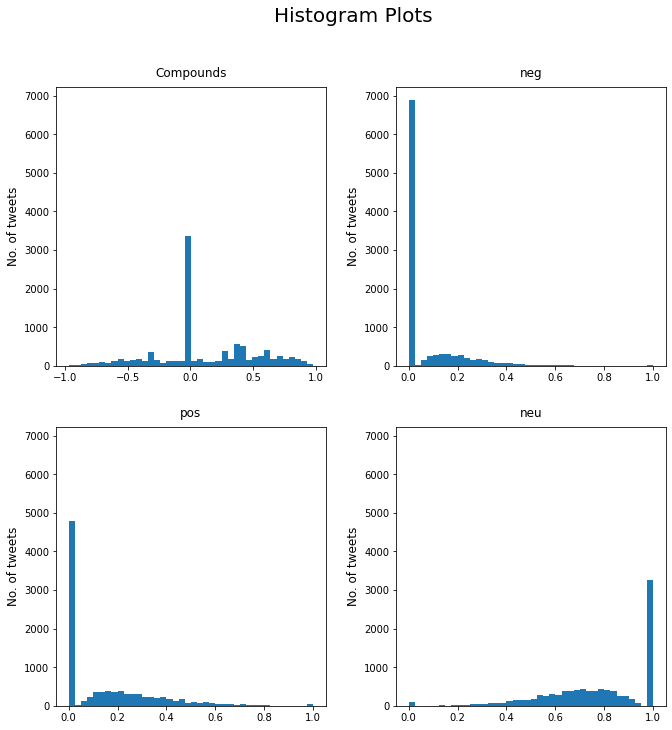

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
fig.tight_layout(pad = 4) # Or equivalently,  "plt.tight_layout()"

fig.suptitle('Histogram Plots', fontsize=20,  y=1.05)

ax1 = plt.subplot(2,2,1)
plt.hist(df['compounds'], bins = 40)
plt.title('Compounds', pad = 10)
plt.ylabel('No. of tweets', fontsize=12) 

plt.subplot(2,2,2, sharey = ax1)
plt.hist(df['neg'], bins = 40)
plt.title('neg', pad = 10)
plt.ylabel('No. of tweets', fontsize=12)

plt.subplot(2,2,3, sharey = ax1)
plt.hist(df['pos'], bins = 40)
plt.title('pos',  pad = 10)
plt.ylabel('No. of tweets', fontsize=12)

plt.subplot(2,2,4, sharey = ax1)
plt.hist(df['neu'], bins = 40)
plt.title('neu',  pad = 10)
plt.ylabel('No. of tweets', fontsize=12)

plt.show()

## Insights and Observations



*   From the histogram we can observe that the overall sentiment is positive to neutral

